In [75]:
import numpy as np
import copy
import os
np.seterr(all='raise') 
import argparse
import csv
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from datetime import datetime
import scipy
from scipy import stats
from scipy.special import gamma, digamma, loggamma

In [76]:
import os
cwd = os.getcwd()
BOW_PATH = cwd + "/Data/ap.dat" 
VOCAB_PATH = cwd + "/Data/vocab.txt"

In [184]:
PATH = os.getcwd()

In [77]:


# Topic Exch. Dirichlet hyperparameter (mixture components)
ETA = 0.01 # Set to 100/V

# Topic Proportion Dirichlet hyperparameter (mixture proportions)
ALPHA = 0.1 # Set to

# Maximum number of iterations (Might not use)
MAX_ITER = 100

# Number of CAVI iterations
N_TRIALS = 1

# Test data size
N_TEST = 10

## Helper 

In [78]:
def compute_logsumexp(scores):
    # Take the max of the scores
    max_score = np.max(scores, axis=0)

    # Subtract scores by max and exponentiate
    exp_scores = np.exp(scores - max_score)

    # Compute denominator
    sum_exp = np.sum(exp_scores)

    # Compute log-sum-exp
    log_sum_exp = np.log(sum_exp) + max_score

    return log_sum_exp


# Loads the AP article dataset
def load_data():
    # Load index-to-word mapping
    print('Loading index-to-word mapping...')

    with open(VOCAB_PATH, 'r') as fh:
        raw_lines = fh.readlines()

    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    # Load article BoW representations
    print('Loading article bag-of-word representations...')

    with open(BOW_PATH, 'r') as fh:
        raw_lines = fh.readlines()
        N = len(raw_lines)
        print('{} articles found.'.format(N))

    articles = np.zeros((N,V))
    nonzero_idxs = []

    # Process each article
    for i in tqdm(range(N)):
        split = raw_lines[i].split(' ')
        n_words = int(split[0]) # Number of words in the article
        split = split[1:] # BoW representations

        article = np.zeros((V,)) # Sparse V-vector
        nonzero_idx = [] # List of indices that have non-zero counts

        for bow in split:
            bow = bow.strip()
            word_idx, count = bow.split(':')

            nonzero_idx.append(int(word_idx))
            article[int(word_idx)] = count

        # Check if article words parsed correctly
        try:
            assert(len(nonzero_idx) == n_words)
        except:
            raise AssertionError('{}, {}'.format(len(nonzero_idx), n_words))

        articles[i] = article
        nonzero_idxs.append(sorted(nonzero_idx))

    return idx_to_words, articles, nonzero_idxs


# Initializes the variational parameters for CAVI
def init_var_param(train_articles, C):
    print('Initializing variational parameters...')

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    # Topics (initializing LAMBDA for BETA)
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(C,V))

    # Topic Proportions (initializing GAMMA for THETA)
    GAMMA = np.ones((N,C)) # Uniform prior

    # Topic Assignments (initializing PHI for Z)
    # Shape: (N,n_words,C) (Note: n_words is vacriable)
    PHI = []

    for article in train_articles:
        n_words = np.sum((article > 0).astype('int32'))
        article_phi = np.ones((n_words,C))
        article_phi = article_phi / C # Initialize to 1/C

        PHI.append(article_phi)

    return LAMBDA, GAMMA, PHI

# Energy Function

In [79]:
def E(p_list,k):
    E = 0
    for i in range(len(p_list) -1):
        E += L(p_list[i]) + 0.5 * k * np.linalg.norm(p_list[i+1] - p_list[i])
    E += 0.5 * k * np.linalg.norm(p_list[-1] - p_list[-2])

    return E

In [80]:
def L(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C):
    #compute elbo
    elbo = 0
    
    # Number of articles, vocabulary size
    N, V = train_articles.shape
    
    # Add expected log joint
    ## First term: \sum_{k=1}^C E[log p(BETA_k)]
    E_log_p_beta = 0
    for k in range(C):
        E_log_p_beta += (ETA-1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    
    elbo += E_log_p_beta
    
    ## Second term: \sum_{i=1}^N E[log p(THETA_i)]
    E_log_p_theta = 0
    for i in range(N):
        E_log_p_theta += (ALPHA-1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))

    elbo += E_log_p_theta
    
    ## Third term:
    ## \sum_{i=1}^N \sum_{j=1}^M \sum_{k=1}^C
    ## (E[log p(Z_ij|THETA_i)] + E[log p(X_ij)|BETA,Z_ij)])
    E_log_p_xz = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]
        
        corr_idx = 0
        for idx in nonzero_idx:
            ### E[log p(Z_ij|THETA_i)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
            
            ### E[log p(X_ij|BETA,Z_ij)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(LAMBDA[:,idx]) - digamma(np.sum(LAMBDA, axis=1))))
            
            corr_idx += 1
        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))
        
    elbo += E_log_p_xz
        
    # Add entropy
    ## Fourth term: -\sum_{k=1}^C E[log q(BETA_k)]
    E_log_q_beta = 0
    for k in range(C):
        E_log_q_beta += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k]))
        E_log_q_beta += -np.sum((LAMBDA[k]-1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    
    elbo += E_log_q_beta
    
    ## Fifth term: -\sum_{i=1}^N E[log q(THETA_i)]
    E_log_q_theta = 0
    for i in range(N):
        E_log_q_theta += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i]))
        E_log_q_theta += -np.sum((GAMMA[i]-1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))

    elbo += E_log_q_theta
    
    
    ## Sixth term: -\sum_{i=1}^N \sum_{j=1}^M (E[log q(Z_ij)])
    E_log_q_z = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        corr_idx = 0
        for idx in nonzero_idx:
            E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(PHI[i][corr_idx]))

            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

    elbo += E_log_q_z

    print('ELBO: {}'.format(elbo))

    return elbo
    

def dLdp(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C): 
    predict_flag = False 
    LAMBDA_t = copy.deepcopy(LAMBDA) # Shape: (C,V)
    GAMMA_t = copy.deepcopy(GAMMA) # Shape: (N,C)
    PHI_t = copy.deepcopy(PHI) # Shape: (N,n_words,C)

    N, V = train_articles.shape

    for i in tqdm(range(N)):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        # Fetch for PHI_ij update
        GAMMA_i_t = copy.deepcopy(GAMMA_t[i]) # C-vector

        # For each word in document
        corr_idx = 0

        # Iterate through each word with non-zero count on document
        for idx in nonzero_idx:
            log_PHI_ij = np.zeros((C,))

            for k in range(C):
                # Fetch for PHI_ij update
                LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k]) # V-vector

                exponent = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t))
                exponent += digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
                log_PHI_ij[k] = exponent

            # Normalize using log-sum-exp trick
            PHI_ij = np.exp(log_PHI_ij - compute_logsumexp(log_PHI_ij))
            try:
                assert(np.abs(np.sum(PHI_ij) - 1) < 1e-6)
            except:
                raise AssertionError('phi_ij: {}, Sum: {}'.format(PHI_ij, np.sum(PHI_ij)))

            PHI_t[i][corr_idx] = PHI_ij
            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

        # Update GAMMA_i
        GAMMA_i_t = np.zeros((C,)) + ALPHA

        for k in range(C):
            GAMMA_i_t[k] += np.sum(article[nonzero_idx] * PHI_t[i][:,k])

        GAMMA_t[i] = GAMMA_i_t

    if not predict_flag:
        # For each topic
        print('Updating LAMBDA')

        for k in tqdm(range(C)):
            LAMBDA_k_t = np.zeros((V,)) + ETA

            # For each document
            for i in range(N):
                article = train_articles[i]
                nonzero_idx = train_nonzero_idxs[i]

                # For each word in document
                corr_idx = 0

                for idx in nonzero_idx:
                    LAMBDA_k_t[idx] += article[idx] * PHI_t[i][corr_idx][k]
                    corr_idx +=1

                # Check if number of updates match with number of words
                assert(corr_idx == len(nonzero_idx))

            LAMBDA_t[k] = LAMBDA_k_t 
    grad_LAMBDA = LAMBDA_t - LAMBDA
    grad_GAMMA = GAMMA_t - GAMMA 
    grad_PHI = [phi_t - phi for (phi_t,phi) in zip(PHI_t, PHI)]

    return grad_LAMBDA, grad_GAMMA, grad_PHI

In [81]:
def tau(i, p_list, train_articles, train_nonzero_idxs, C):
    #p_list is a list of lists of parameters in which a list is [LAMBDA, GAMMA, PHI] 
    LAMBDA_1, GAMMA_1, PHI_1 = p_list[i] 
    LAMBDA_0, GAMMA_0, PHI_0 = p_list[i-1] 
    LAMBDA_2, GAMMA_2, PHI_2 = p_list[i+1] 

    if compute_elbo( LAMBDA_2, GAMMA_2, PHI_2, train_articles, train_nonzero_idxs, C) > compute_elbo( LAMBDA_0, GAMMA_0, PHI_0 , train_articles, train_nonzero_idxs, C): 
        flat_Lam = np.reshape((LAMBDA_2-LAMBDA_1).flatten(),((LAMBDA_2-LAMBDA_1).flatten().shape[0],1))
        #print(flat_Lam.shape)
        flat_Gam = np.reshape((GAMMA_2 - GAMMA_1).flatten(),((GAMMA_2 - GAMMA_1).flatten().shape[0],1))
        #print(flat_Gam.shape)
        flat_vector = np.vstack((flat_Lam, flat_Gam))
        #print(flat_vector.shape)

        #flat_Phi = (PHI_2-PHI_1).flatten() 
        dif_PHI = [Phi_2-Phi_1 for (Phi_2,Phi_1) in zip(PHI_2,PHI_1)] 
        for dif in dif_PHI: 
            flat_dif = dif.flatten().reshape(dif.flatten().shape[0],1)
            #print(flat_dif.shape)
            flat_vector = np.vstack((flat_vector, flat_dif)) 

        norm = np.linalg.norm(flat_vector)+ 1e-30

        lam_dif = (LAMBDA_2-LAMBDA_1)/norm
        gam_dif = (GAMMA_2 - GAMMA_1)/norm 
        PHI_dif = [dif_phi/norm for dif_phi in dif_PHI]

        return [lam_dif, gam_dif, PHI_dif]
    #TODO: what is the right way to normalize 
    else: 
        flat_Lam = np.reshape((LAMBDA_1-LAMBDA_0).flatten(),((LAMBDA_1-LAMBDA_0).flatten().shape[0],1))
        #print(flat_Lam.shape)
        flat_Gam = np.reshape((GAMMA_1 - GAMMA_0).flatten(),((GAMMA_1 - GAMMA_0).flatten().shape[0],1))
        #print(flat_Gam.shape)
        flat_vector = np.vstack((flat_Lam, flat_Gam))

        #flat_Phi = (PHI_1-PHI_0).flatten() 
        dif_PHI = [Phi_1-Phi_0 for (Phi_1,Phi_0) in zip(PHI_1,PHI_0)] 
        for dif in dif_PHI: 
            flat_dif = dif.flatten().reshape(dif.flatten().shape[0],1)
            flat_vector = np.vstack((flat_vector, flat_dif)) 

        norm = np.linalg.norm(flat_vector)+ 1e-30
        lam_dif = (LAMBDA_1-LAMBDA_0)/norm
        gam_dif = (GAMMA_1 - GAMMA_0)/norm 
        PHI_dif = [dif_phi/norm for dif_phi in dif_PHI]

        return [lam_dif, gam_dif, PHI_dif]
        #return [(LAMBDA_1-LAMBDA_0)/norm, (GAMMA_1 - GAMMA_0)/norm, [dif_phi for dif_phi in dif_PHI/norm]]

In [82]:
def F_L(i, p_list, train_articles, train_nonzero_idxs, C):

  LAMBDA, GAMMA, PHI = p_list[i]
  tau_Lam, tau_Gam, tau_Phi = tau(i, p_list, train_articles, train_nonzero_idxs, C)
  grad_LAMBDA, grad_GAMMA, grad_PHI = dLdp(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)
  grad_dot_tau_Lam = np.multiply(grad_LAMBDA , tau_Lam)
  grad_dot_tau_Gam = np.multiply(grad_GAMMA , tau_Gam)
  grad_dot_tau_Phi = [np.multiply(grad_p ,tau_p) for (grad_p, tau_p) in zip (grad_PHI, tau_Phi)]
  F_L_Lam = -(grad_LAMBDA - grad_dot_tau_Lam*tau_Lam )
  F_L_Gam = -(grad_GAMMA - grad_dot_tau_Gam*tau_Gam )
  F_L_Phi = [-(grad_p - gdt_p*tau_p) for (grad_p, gdt_p, tau_p) in zip (grad_PHI, grad_dot_tau_Phi, tau_Phi) ]
  return F_L_Lam, F_L_Gam, F_L_Phi
  #return -(dLdp(p_list[i]) - np.dot(dLdp(p_list[i]), tau(i, p_list)) *  tau(i, p_list))

def F_s(i, k, p_list):
  LAMBDA_1, GAMMA_1, PHI_1 = p_list[i] 
  LAMBDA_2, GAMMA_2, PHI_2 = p_list[i+1]  
  k_LAMBDA_Diff =  k * (LAMBDA_1 - LAMBDA_2)
  k_GAMMA_Diff =  k * (GAMMA_1 - GAMMA_2)
  k_PHI_Diff = [k*(curr - next) for (curr,next) in zip(PHI_1,PHI_2)]

  return k_LAMBDA_Diff, k_GAMMA_Diff, k_PHI_Diff

In [83]:
def init(theta_1, theta_2, N):
    LAMBDA_1, GAMMA_1, PHI_1 = theta_1
    LAMBDA_2, GAMMA_2, PHI_2 = theta_2

    interval = np.linspace(0,1,N+1)
  
    p_list = []

    for i in interval:
        NEW_LAMBDA = (LAMBDA_2 - LAMBDA_1) * i + LAMBDA_1
        NEW_GAMMA = (GAMMA_2 - GAMMA_1) * i + GAMMA_1
        NEW_PHI = [(Phi_2 - Phi_1) * i + Phi_1 for (Phi_1,Phi_2) in zip(PHI_1,PHI_2)]
        p_list.append([NEW_LAMBDA, NEW_GAMMA, NEW_PHI]) 


    return p_list

In [84]:
np.linspace(0,1,3)

array([0. , 0.5, 1. ])

##Load data and get parameters 

In [85]:
cwd = os.getcwd()
BOW_PATH = cwd + "/Data/ap.dat" 
VOCAB_PATH = cwd + "/Data/vocab.txt" 

# Topic Exch. Dirichlet hyperparameter (mixture components)
ETA = 0.01 # Set to 100/V

# Topic Proportion Dirichlet hyperparameter (mixture proportions)
ALPHA = 0.1 # Set to

# Maximum number of iterations (Might not use)
MAX_ITER = 100

# Number of CAVI iterations
N_TRIALS = 1

# Test data size
N_TEST = 10

# Computes the softmax for a given set of scores
# Scores will be log probability of each assignment
# Note: Uses log-sum-exp trick to avoid overflow/underflow
def compute_logsumexp(scores):
    # Take the max of the scores
    max_score = np.max(scores, axis=0)

    # Subtract scores by max and exponentiate
    # result = 
    exp_scores = np.exp(scores - max_score)

    # Compute denominator
    sum_exp = np.sum(exp_scores)

    # Compute log-sum-exp
    log_sum_exp = np.log(sum_exp) + max_score

    return log_sum_exp

# Loads the AP article dataset
def load_data():
    # Load index-to-word mapping
    print('Loading index-to-word mapping...')

    with open(VOCAB_PATH, 'r') as fh:
        raw_lines = fh.readlines()

    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    # Load article BoW representations
    print('Loading article bag-of-word representations...')

    with open(BOW_PATH, 'r') as fh:
        raw_lines = fh.readlines()
        N = len(raw_lines)
        print('{} articles found.'.format(N))

    articles = np.zeros((N,V))
    nonzero_idxs = []

    # Process each article
    for i in tqdm(range(N)):
        split = raw_lines[i].split(' ')
        n_words = int(split[0]) # Number of words in the article
        split = split[1:] # BoW representations

        article = np.zeros((V,)) # Sparse V-vector
        nonzero_idx = [] # List of indices that have non-zero counts

        for bow in split:
            bow = bow.strip()
            word_idx, count = bow.split(':')

            nonzero_idx.append(int(word_idx))
            article[int(word_idx)] = count

        # Check if article words parsed correctly
        try:
            assert(len(nonzero_idx) == n_words)
        except:
            raise AssertionError('{}, {}'.format(len(nonzero_idx), n_words))

        articles[i] = article
        nonzero_idxs.append(sorted(nonzero_idx))

    return idx_to_words, articles, nonzero_idxs





# Initializes the variational parameters for CAVI
def init_var_param(train_articles, C):
    print('Initializing variational parameters...')

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    # Topics (initializing LAMBDA for BETA)
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(C,V))

    # Topic Proportions (initializing GAMMA for THETA)
    GAMMA = np.ones((N,C)) # Uniform prior

    # Topic Assignments (initializing PHI for Z)
    # Shape: (N,n_words,C) (Note: n_words is vacriable)
    PHI = []

    for article in train_articles:
        n_words = np.sum((article > 0).astype('int32'))
        article_phi = np.ones((n_words,C))
        article_phi = article_phi / C # Initialize to 1/C

        PHI.append(article_phi)

    return LAMBDA, GAMMA, PHI

# Compute ELBO
def compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C):
    elbo = 0

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    # Add expected log joint
    ## First term: \sum_{k=1}^C E[log p(BETA_k)]
    E_log_p_beta = 0
    for k in range(C):
        E_log_p_beta += (ETA-1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))

    elbo += E_log_p_beta

    ## Second term: \sum_{i=1}^N E[log p(THETA_i)]
    E_log_p_theta = 0
    for i in range(N):
        E_log_p_theta += (ALPHA-1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))

    elbo += E_log_p_theta

    ## Third term:
    ## \sum_{i=1}^N \sum_{j=1}^M \sum_{k=1}^C
    ## (E[log p(Z_ij|THETA_i)] + E[log p(X_ij)|BETA,Z_ij)])
    E_log_p_xz = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        corr_idx = 0

        for idx in nonzero_idx:
            ### E[log p(Z_ij|THETA_i)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))

            ### E[log p(X_ij|BETA,Z_ij)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(LAMBDA[:,idx]) - digamma(np.sum(LAMBDA, axis=1))))

            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

    elbo += E_log_p_xz

    # Add entropy
    ## Fourth term: -\sum_{k=1}^C E[log q(BETA_k)]
    E_log_q_beta = 0
    for k in range(C):
        E_log_q_beta += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k]))
        E_log_q_beta += -np.sum((LAMBDA[k]-1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))

    elbo += E_log_q_beta

    ## Fifth term: -\sum_{i=1}^N E[log q(THETA_i)]
    E_log_q_theta = 0
    for i in range(N):
        E_log_q_theta += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i]))
        E_log_q_theta += -np.sum((GAMMA[i]-1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))

    elbo += E_log_q_theta

    ## Sixth term: -\sum_{i=1}^N \sum_{j=1}^M (E[log q(Z_ij)])
    E_log_q_z = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        corr_idx = 0
        for idx in nonzero_idx:
            #print(PHI[i][corr_idx])
            #print(type(PHI[i][corr_idx]))
            #print(PHI[i][corr_idx]+1e-1)
            E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(np.abs((PHI[i][corr_idx]+1e-6))/(np.linalg.norm(PHI[i][corr_idx]+1e-6)+1e-20)))
            #E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(np.minimum(PHI[i][corr_idx],1e-9)))/(np.linalg.norm(PHI[i][corr_idx])+1e-20)
            #E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(np.abs(PHI[i][corr_idx])))

            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

    elbo += E_log_q_z

    print('ELBO: {}'.format(elbo))

    return elbo

# Runs CAVI for LDA
# TODO: Change max iteration to convergence criterion
def run_cavi(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C, max_iter, predict_flag=False):
    # Unpack initial variational parameters
    LAMBDA_t = copy.deepcopy(LAMBDA) # Shape: (C,V)
    GAMMA_t = copy.deepcopy(GAMMA) # Shape: (N,C)
    PHI_t = copy.deepcopy(PHI) # Shape: (N,n_words,C)

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    elbos = []

    print('Running CAVI for LDA (C: {}, Iter: {})...'.format(C, max_iter))
    for t in range(max_iter):
        print('Iteration {}'.format(t+1))
        print('Updating PHI and GAMMA')

        # For each document
        for i in tqdm(range(N)):
            article = train_articles[i]
            nonzero_idx = train_nonzero_idxs[i]

            # Fetch for PHI_ij update
            GAMMA_i_t = copy.deepcopy(GAMMA_t[i]) # C-vector

            # For each word in document
            corr_idx = 0

            # Iterate through each word with non-zero count on document
            for idx in nonzero_idx:
                log_PHI_ij = np.zeros((C,))

                for k in range(C):
                    # Fetch for PHI_ij update
                    LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k]) # V-vector

                    exponent = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t))
                    exponent += digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
                    log_PHI_ij[k] = exponent

                # Normalize using log-sum-exp trick
                PHI_ij = np.exp(log_PHI_ij - compute_logsumexp(log_PHI_ij))
                try:
                    assert(np.abs(np.sum(PHI_ij) - 1) < 1e-6)
                except:
                    raise AssertionError('phi_ij: {}, Sum: {}'.format(PHI_ij, np.sum(PHI_ij)))

                PHI_t[i][corr_idx] = PHI_ij
                corr_idx += 1

            # Check if number of updates match with number of words
            assert(corr_idx == len(nonzero_idx))

            # Update GAMMA_i
            GAMMA_i_t = np.zeros((C,)) + ALPHA

            for k in range(C):
                GAMMA_i_t[k] += np.sum(article[nonzero_idx] * PHI_t[i][:,k])

            GAMMA_t[i] = GAMMA_i_t

        if not predict_flag:
            # For each topic
            print('Updating LAMBDA')

            for k in tqdm(range(C)):
                LAMBDA_k_t = np.zeros((V,)) + ETA

                # For each document
                for i in range(N):
                    article = train_articles[i]
                    nonzero_idx = train_nonzero_idxs[i]

                    # For each word in document
                    corr_idx = 0

                    for idx in nonzero_idx:
                        LAMBDA_k_t[idx] += article[idx] * PHI_t[i][corr_idx][k]
                        corr_idx +=1

                    # Check if number of updates match with number of words
                    assert(corr_idx == len(nonzero_idx))

                LAMBDA_t[k] = LAMBDA_k_t

        # Compute ELBO
        elbo = compute_elbo(LAMBDA_t, GAMMA_t, PHI_t, train_articles, train_nonzero_idxs, C)
        elbos.append(elbo)

    LAMBDA_final = copy.deepcopy(LAMBDA_t)
    GAMMA_final = copy.deepcopy(GAMMA_t)
    PHI_final = copy.deepcopy(PHI_t)

    return LAMBDA_final, GAMMA_final, PHI_final, elbos

def filter_train_words(idx_to_words, train_nonzero_idxs):
    # Number of train articles, vocabulary size
    N, V = train_articles.shape

    train_word_idxs = []

    for i in range(N):

        nonzero_idx = train_nonzero_idxs[i]
        train_word_idxs += nonzero_idx

    train_word_idxs = set(train_word_idxs)
    test_word_idxs = set(range(V)) - train_word_idxs

    return test_word_idxs

# Computes the predictive likelihood score on held out articles
def compute_pred_score(LAMBDA, GAMMA, PHI, test_articles, test_nonzero_idxs, test_word_idxs):
    # Number of test articles, vocabulary size
    N,V = test_articles.shape

    C = LAMBDA.shape[0]

    # Expected BETA
    BETA = np.zeros((C,V))

    for k in range(C):
        BETA[k] = LAMBDA[k] / np.sum(LAMBDA[k])

    # Expected THETA
    THETA = np.zeros((N,C))

    for i in range(N):
        THETA[i] = GAMMA[i] / np.sum(GAMMA[i])

    # Compute predictive likelihood
    print('Computing predictive likelihood score on held out documents...')

    score = 0
    for i in tqdm(range(N)):
        article = test_articles[i]
        nonzero_idx = test_nonzero_idxs[i]

        for idx in nonzero_idx:
            if not idx in test_word_idxs:
                score += np.log(np.dot(THETA[i], BETA[:,idx]))

    print('Predictive likelihood: {}'.format(score))

    return score



In [197]:
cwd = os.getcwd()
BOW_PATH = cwd + "/Data/ap.dat" 
VOCAB_PATH = cwd + "/Data/vocab.txt"

#load_data 

def load_data(BOW_PATH,VOCAB_PATH, trim):
    # Load index-to-word mapping
    print('Loading index-to-word mapping...')

    with open(VOCAB_PATH, 'r') as fh:
        raw_lines = fh.readlines()

    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    # Load article BoW representations
    print('Loading article bag-of-word representations...')

    with open(BOW_PATH, 'r') as fh:
        raw_lines = fh.readlines()
        raw_lines = raw_lines[:np.int(trim*len(raw_lines))]
        N = len(raw_lines)
        print('{} articles found.'.format(N))

    articles = np.zeros((N,V))
    nonzero_idxs = []

    # Process each article
    for i in tqdm(range(N)):
        split = raw_lines[i].split(' ')
        n_words = int(split[0]) # Number of words in the article
        split = split[1:] # BoW representations

        article = np.zeros((V,)) # Sparse V-vector
        nonzero_idx = [] # List of indices that have non-zero counts

        for bow in split:
            bow = bow.strip()
            word_idx, count = bow.split(':')

            nonzero_idx.append(int(word_idx))
            article[int(word_idx)] = count

        # Check if article words parsed correctly
        try:
            assert(len(nonzero_idx) == n_words)
        except:
            raise AssertionError('{}, {}'.format(len(nonzero_idx), n_words))

        articles[i] = article
        nonzero_idxs.append(sorted(nonzero_idx))

    return idx_to_words, articles, nonzero_idxs

In [264]:
pred_score_list = []

/var/folders/mw/9bfg1rf52g57tm0mgxqjy4gm0000gn/T/ipykernel_55007/2775555696.py:22: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Loading AP article data...
Loading index-to-word mapping...
Loading article bag-of-word representations...
112 articles found.


100%|██████████████████████████████████████| 112/112 [00:00<00:00, 12386.93it/s]


Running LDA CAVI 1/1...
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.67it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 231.20it/s]


ELBO: 190743.8428323853
Iteration 2
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 62.11it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.58it/s]


ELBO: 224621.56759740593
Iteration 3
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 64.84it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 238.48it/s]


ELBO: 246557.3616926157
Iteration 4
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.53it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 239.46it/s]


ELBO: 260490.4333992779
Iteration 5
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.85it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.77it/s]


ELBO: 270099.65547781443
Iteration 6
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.65it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 244.26it/s]


ELBO: 277132.3384994109
Iteration 7
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 67.16it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 244.86it/s]


ELBO: 282161.1938998254
Iteration 8
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.91it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 240.30it/s]


ELBO: 285682.3914911684
Iteration 9
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.90it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 240.04it/s]


ELBO: 288146.9133290137
Iteration 10
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.83it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 240.33it/s]


ELBO: 289832.0686389417
Iteration 11
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 67.00it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 246.41it/s]


ELBO: 291066.7129189073
Iteration 12
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.70it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 238.19it/s]


ELBO: 292006.2776933267
Iteration 13
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.91it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 243.48it/s]


ELBO: 292701.91819717945
Iteration 14
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.88it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 243.31it/s]


ELBO: 293257.0996604176
Iteration 15
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.99it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 240.12it/s]


ELBO: 293711.8481563879
Iteration 16
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.96it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 240.89it/s]


ELBO: 294083.04380896484
Iteration 17
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.81it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 237.15it/s]


ELBO: 294386.61206175515
Iteration 18
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.87it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 239.38it/s]


ELBO: 294635.0008297746
Iteration 19
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.57it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 231.27it/s]


ELBO: 294848.2876164357
Iteration 20
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 62.11it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 221.20it/s]


ELBO: 295023.08405143884


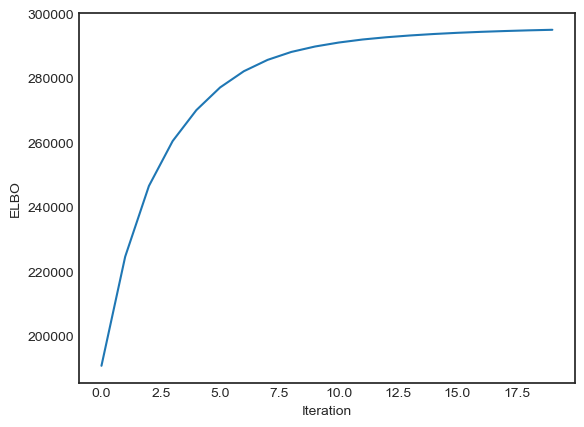

ELBO plot saved.
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 74.92it/s]


ELBO: 412329.3533364112
Iteration 2
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 77.47it/s]


ELBO: 412390.47750288795
Iteration 3
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.46it/s]


ELBO: 412408.8527154081
Iteration 4
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 79.42it/s]


ELBO: 412414.6864055165
Iteration 5
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 75.06it/s]


ELBO: 412416.5943268953
Iteration 6
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.93it/s]


ELBO: 412417.1670011046
Iteration 7
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 76.90it/s]


ELBO: 412417.38190120907
Iteration 8
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 75.54it/s]


ELBO: 412417.46583273174
Iteration 9
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 74.25it/s]


ELBO: 412417.4995190774
Iteration 10
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 75.15it/s]


ELBO: 412417.513365401
Iteration 11
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 75.55it/s]


ELBO: 412417.5191802529
Iteration 12
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 77.16it/s]


ELBO: 412417.52167074673
Iteration 13
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 76.55it/s]


ELBO: 412417.52275700244
Iteration 14
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.86it/s]


ELBO: 412417.5232388508
Iteration 15
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 70.97it/s]


ELBO: 412417.52345596236
Iteration 16
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.57it/s]


ELBO: 412417.52355521783
Iteration 17
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.16it/s]


ELBO: 412417.5236011984
Iteration 18
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 73.12it/s]


ELBO: 412417.5236227598
Iteration 19
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 76.43it/s]


ELBO: 412417.5236329845
Iteration 20
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 73.40it/s]


ELBO: 412417.52363787807
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4970.14it/s]

Predictive likelihood: -7523.252314482869
Total run-time: 0:0:45


<Figure size 640x480 with 0 Axes>

In [436]:
C = 10 #num of topics 
#use_cached = kwargs['use_cached']
predict_flag = True
max_iter = 20
n_trials = 1
trim = 0.05

start_time = datetime.now()

global ALPHA
ALPHA = 1 / C

# Load data
print('Loading AP article data...')
idx_to_words, articles, nonzero_idxs = load_data(BOW_PATH,VOCAB_PATH, trim)

# Split data into train/test

train_articles = articles[:-N_TEST]
train_nonzero_idxs = nonzero_idxs[:-N_TEST]
test_articles = articles[-N_TEST:]
test_nonzero_idxs = nonzero_idxs[-N_TEST:]

#var_param_dict = {}
colors = matplotlib.cm.tab10(np.linspace(0,1,n_trials))
best_trial = 0
best_elbo = -np.inf

for trial in range(n_trials):
    print('Running LDA CAVI {}/{}...'.format(trial+1, n_trials))

    # Initialize variational parameters
    LAMBDA, GAMMA, PHI = init_var_param(train_articles, C)

    # Run CAVI
    LAMBDA_final, GAMMA_final, PHI_final, elbos = run_cavi(LAMBDA, GAMMA, PHI, train_articles,
                                                            train_nonzero_idxs, C, max_iter)

    elbo_final = elbos[-1]

    if elbo_final > best_elbo:
        best_trial = trial
        best_elbo = elbo_final
        
    '''
    var_param_dict[trial] = {'LAMBDA': LAMBDA_final,
                              'GAMMA': GAMMA_final,
                              'PHI': PHI_final,
                              'elbos': elbos}
    '''
    # Plot ELBO
    plt.plot(np.arange(0, max_iter), elbos, label=trial+1, color=colors[trial])

#plt.legend()
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.show()
plt.savefig('./elbo_plot_{}_{}.png'.format(C, max_iter))
print('ELBO plot saved.')

# Compute predictive likelihood score on held out test articles
if predict_flag:
    
    #LAMBDA_fixed = var_param_dict[best_trial]['LAMBDA']
    LAMBDA_fixed = LAMBDA_final

    # Initialize variational parameters
    _, GAMMA, PHI = init_var_param(test_articles, C)

    # Run CAVI
    LAMBDA_pred, GAMMA_pred, PHI_pred, elbos = run_cavi(LAMBDA_fixed, GAMMA, PHI, test_articles,
                                                        test_nonzero_idxs, C, max_iter, predict_flag=True)
    test_word_idxs = []
    # Compute predictive likelihood
    test_word_idxs = filter_train_words(idx_to_words, train_nonzero_idxs)
    pred_score = compute_pred_score(LAMBDA_pred, GAMMA_pred, PHI_pred, test_articles,
                                    test_nonzero_idxs, test_word_idxs)
    #var_param_dict['score'] = pred_score
    pred_score_list.append(pred_score)

# Save inferred variational parameters
'''
with open('var_params_{}_{}.pkl'.format(C, max_iter), 'wb') as fh:
    pickle.dump(var_param_dict, fh)
    print('Inferred variational parameters saved.')
'''

end_time = datetime.now()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time.seconds, 3600)
minutes, seconds = divmod(rem, 60)
print('Total run-time: {}:{}:{}'.format(hours, minutes, seconds))


In [437]:
theta1 = [LAMBDA_final, GAMMA_final, PHI_final] 

Running LDA CAVI 1/1...
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 63.27it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 221.37it/s]


ELBO: 190237.30741173364
Iteration 2
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 61.95it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 234.78it/s]


ELBO: 224274.8924424391
Iteration 3
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 63.23it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 234.75it/s]


ELBO: 246620.0926130829
Iteration 4
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.55it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 248.17it/s]


ELBO: 260589.3611195274
Iteration 5
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.76it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 248.04it/s]


ELBO: 270280.49868342816
Iteration 6
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 64.17it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.58it/s]


ELBO: 277334.63892278087
Iteration 7
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 63.47it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 248.29it/s]


ELBO: 282363.09187826765
Iteration 8
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 63.14it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 243.02it/s]


ELBO: 285857.84363307693
Iteration 9
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 62.88it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 229.54it/s]


ELBO: 288308.38194804743
Iteration 10
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 64.24it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 219.99it/s]


ELBO: 290041.7678401544
Iteration 11
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.20it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 240.81it/s]


ELBO: 291296.26406185154
Iteration 12
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 64.90it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 239.33it/s]


ELBO: 292267.5850805671
Iteration 13
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.52it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.15it/s]


ELBO: 292941.4144833076
Iteration 14
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.39it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 243.10it/s]


ELBO: 293487.462714558
Iteration 15
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.22it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 244.79it/s]


ELBO: 293908.3803038925
Iteration 16
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.61it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 247.51it/s]


ELBO: 294261.7942008053
Iteration 17
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.98it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 246.42it/s]


ELBO: 294541.94386638835
Iteration 18
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.19it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 230.01it/s]


ELBO: 294767.6093015858
Iteration 19
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.07it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 243.19it/s]


ELBO: 294964.99131317413
Iteration 20
Updating PHI and GAMMA


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.21it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 240.88it/s]


ELBO: 295142.4218413101


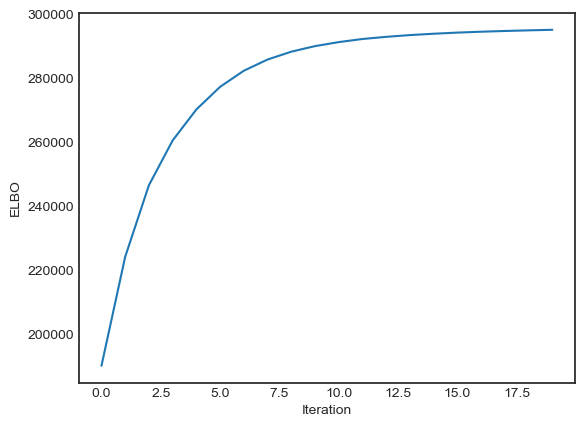

ELBO plot saved.
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 76.73it/s]


ELBO: 412332.2423370488
Iteration 2
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 79.15it/s]


ELBO: 412395.8595332113
Iteration 3
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 77.74it/s]


ELBO: 412416.71630691824
Iteration 4
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.62it/s]


ELBO: 412423.7650723413
Iteration 5
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 79.10it/s]


ELBO: 412426.22946960735
Iteration 6
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.66it/s]


ELBO: 412427.37975474907
Iteration 7
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.73it/s]


ELBO: 412428.2030902159
Iteration 8
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.34it/s]


ELBO: 412428.8996283931
Iteration 9
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.46it/s]


ELBO: 412429.11076480837
Iteration 10
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.12it/s]


ELBO: 412429.18479715666
Iteration 11
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.81it/s]


ELBO: 412429.2414264843
Iteration 12
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.37it/s]


ELBO: 412429.29267204535
Iteration 13
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 77.98it/s]


ELBO: 412429.34602486965
Iteration 14
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.41it/s]


ELBO: 412429.4087659653
Iteration 15
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.54it/s]


ELBO: 412429.49123297975
Iteration 16
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 74.12it/s]


ELBO: 412429.6116136825
Iteration 17
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 73.49it/s]


ELBO: 412429.8048171568
Iteration 18
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.56it/s]


ELBO: 412430.1323874054
Iteration 19
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 74.52it/s]


ELBO: 412430.56544300844
Iteration 20
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 76.13it/s]


ELBO: 412430.67180892034
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 5537.77it/s]

Predictive likelihood: -7511.532917195805
Total run-time: 0:1:33


<Figure size 640x480 with 0 Axes>

In [438]:
'''
C = 10 #num of topics 
#use_cached = kwargs['use_cached']
predict_flag = True
max_iter = 20
n_trials = 1
trim = 0.01

start_time = datetime.now()

global ALPHA
ALPHA = 1 / C

# Load data
print('Loading AP article data...')
idx_to_words, articles, nonzero_idxs = load_data(BOW_PATH,VOCAB_PATH, trim)

# Split data into train/test

train_articles = articles[:-N_TEST]
train_nonzero_idxs = nonzero_idxs[:-N_TEST]
test_articles = articles[-N_TEST:]
test_nonzero_idxs = nonzero_idxs[-N_TEST:]
'''

#var_param_dict = {}
colors = matplotlib.cm.tab10(np.linspace(0,1,n_trials))
best_trial = 0
best_elbo = -np.inf

for trial in range(n_trials):
    print('Running LDA CAVI {}/{}...'.format(trial+1, n_trials))

    # Initialize variational parameters
    LAMBDA, GAMMA, PHI = init_var_param(train_articles, C)

    # Run CAVI
    LAMBDA_final, GAMMA_final, PHI_final, elbos = run_cavi(LAMBDA, GAMMA, PHI, train_articles,
                                                            train_nonzero_idxs, C, max_iter)

    elbo_final = elbos[-1]

    if elbo_final > best_elbo:
        best_trial = trial
        best_elbo = elbo_final
        
    '''
    var_param_dict[trial] = {'LAMBDA': LAMBDA_final,
                              'GAMMA': GAMMA_final,
                              'PHI': PHI_final,
                              'elbos': elbos}
    '''
    # Plot ELBO
    plt.plot(np.arange(0, max_iter), elbos, label=trial+1, color=colors[trial])

#plt.legend()
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.show()
plt.savefig('./elbo_plot_{}_{}.png'.format(C, max_iter))
print('ELBO plot saved.')

# Compute predictive likelihood score on held out test articles
if predict_flag:
    
    #LAMBDA_fixed = var_param_dict[best_trial]['LAMBDA']
    LAMBDA_fixed = LAMBDA_final

    # Initialize variational parameters
    _, GAMMA, PHI = init_var_param(test_articles, C)

    # Run CAVI
    LAMBDA_pred, GAMMA_pred, PHI_pred, elbos = run_cavi(LAMBDA_fixed, GAMMA, PHI, test_articles,
                                                        test_nonzero_idxs, C, max_iter, predict_flag=True)
    test_word_idxs = []
    # Compute predictive likelihood
    test_word_idxs = filter_train_words(idx_to_words, train_nonzero_idxs)
    pred_score = compute_pred_score(LAMBDA_pred, GAMMA_pred, PHI_pred, test_articles,
                                    test_nonzero_idxs, test_word_idxs)
    #var_param_dict['score'] = pred_score
    pred_score_list.append(pred_score)

# Save inferred variational parameters
'''
with open('var_params_{}_{}.pkl'.format(C, max_iter), 'wb') as fh:
    pickle.dump(var_param_dict, fh)
    print('Inferred variational parameters saved.')
'''

end_time = datetime.now()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time.seconds, 3600)
minutes, seconds = divmod(rem, 60)
print('Total run-time: {}:{}:{}'.format(hours, minutes, seconds))


In [439]:
theta2 = [LAMBDA_final, GAMMA_final, PHI_final] 

### what are the most probable words? 

theta1

In [440]:
most_freq_words_1 = [] 

for k in range(C): 
  row = theta1[0][k] 
  ind = np.argpartition(row, -10)[-10:] 
  words = []
  for i in ind: 
    words.append(idx_to_words[i])
  most_freq_words_1.append(words)

In [441]:
for words in most_freq_words_1:
    print(words)

['six', 'country', 'go', 'world', 'believe', 'dukakis', 'states', 'united', 'saturday', 'state']
['time', 'military', 'two', 'first', 'officials', 'year', 'soviet', 'last', 'leaders', 'bank']
['statement', 'duracell', 'children', 'american', 'agreement', 'company', 'york', 'embassy', 'like', 'barry']
['end', 'died', 'fire', 'monday', 'friday', 'price', 'year', 'people', 'three', 'tuesday']
['take', 'meeting', 'congress', 'defense', 'union', 'asked', 'northwest', 'head', 'earlier', 'today']
['area', 'work', 'man', 'police', 'billion', 'two', 'week', 'officers', 'new', 'california']
['campaign', 'administration', 'made', 'thats', 'bush', 'told', 'group', 'people', 'official', 'i']
['economy', 'news', 'prices', 'rose', 'federal', 'oil', 'report', 'government', 'percent', 'new']
['noriega', 'mrs', 'security', 'wednesday', 'high', 'government', 'city', 'states', 'central', 'president']
['president', 'economic', 'national', 'new', 'business', 'year', 'rate', 'years', 'percent', 'i']


In [447]:
pd.DataFrame(most_freq_words_1)

,0,1,2,3,4,5,6,7,8,9
0,six,country,go,world,believe,dukakis,states,united,saturday,state
1,time,military,two,first,officials,year,soviet,last,leaders,bank
2,statement,duracell,children,american,agreement,company,york,embassy,like,barry
3,end,died,fire,monday,friday,price,year,people,three,tuesday
4,take,meeting,congress,defense,union,asked,northwest,head,earlier,today
5,area,work,man,police,billion,two,week,officers,new,california
6,campaign,administration,made,thats,bush,told,group,people,official,i
7,economy,news,prices,rose,federal,oil,report,government,percent,new
8,noriega,mrs,security,wednesday,high,government,city,states,central,president
9,president,economic,national,new,business,year,rate,years,percent,i


In [461]:
pd.DataFrame(most_freq_words_2)

,0,1,2,3,4,5,6,7,8,9
0,businesses,saudi,today,defense,made,top,group,officials,company,union
1,died,years,last,police,new,two,first,office,school,soviet
2,west,mrs,jackson,police,meeting,monday,southern,people,told,united
3,million,months,economy,going,get,last,year,billion,prices,i
4,record,increased,california,federal,month,national,think,percent,rate,business
5,animals,county,service,world,friday,price,leaders,fire,make,war
6,officers,countries,news,saying,campaign,states,washington,official,president,state
7,money,military,million,oil,wednesday,program,soviet,people,city,government
8,time,northwest,week,plan,back,head,man,talks,bank,new
9,noriega,asked,economic,dukakis,roberts,two,good,american,bush,i


In [463]:
most_freq_words_p = [] 
pivot = His[-1][2]
for k in range(C): 
    row = pivot[0][k] 
    ind = np.argpartition(row, -10)[-10:] 
    word = []
    for i in ind: 
        word.append(idx_to_words[i])
    most_freq_words_p.append(word)

In [464]:
pd.DataFrame(most_freq_words_p)

,0,1,2,3,4,5,6,7,8,9
0,group,made,today,top,saudi,defense,union,company,officials,state
1,new,officials,year,school,last,years,first,soviet,police,two
2,united,police,west,told,mexico,meeting,monday,people,central,southern
3,million,people,economy,get,prices,billion,months,i,year,last
4,national,record,think,federal,increased,business,month,percent,rate,california
5,global,world,man,service,county,war,waste,fire,make,leaders
6,news,people,party,states,saying,official,campaign,bush,president,state
7,forces,people,report,money,new,government,million,program,city,oil
8,rating,new,president,head,talks,bank,plan,week,northwest,back
9,good,believe,times,dont,roberts,two,american,economic,dukakis,i


theta2 

In [459]:
most_freq_words_2 = [] 

for k in range(C): 
  row = theta2[0][k] 
  ind = np.argpartition(row, -10)[-10:] 
  words = []
  for i in ind: 
    words.append(idx_to_words[i])
  most_freq_words_2.append(words)

In [460]:
most_freq_words_2

[['businesses',
  'saudi',
  'today',
  'defense',
  'made',
  'top',
  'group',
  'officials',
  'company',
  'union'],
 ['died',
  'years',
  'last',
  'police',
  'new',
  'two',
  'first',
  'office',
  'school',
  'soviet'],
 ['west',
  'mrs',
  'jackson',
  'police',
  'meeting',
  'monday',
  'southern',
  'people',
  'told',
  'united'],
 ['million',
  'months',
  'economy',
  'going',
  'get',
  'last',
  'year',
  'billion',
  'prices',
  'i'],
 ['record',
  'increased',
  'california',
  'federal',
  'month',
  'national',
  'think',
  'percent',
  'rate',
  'business'],
 ['animals',
  'county',
  'service',
  'world',
  'friday',
  'price',
  'leaders',
  'fire',
  'make',
  'war'],
 ['officers',
  'countries',
  'news',
  'saying',
  'campaign',
  'states',
  'washington',
  'official',
  'president',
  'state'],
 ['money',
  'military',
  'million',
  'oil',
  'wednesday',
  'program',
  'soviet',
  'people',
  'city',
  'government'],
 ['time',
  'northwest',
  'week',
 

## CHONG

In [449]:
T = 100
N = 3
p_list = init(theta1, theta2, N)
k = 0.01
lr = 0.1

In [450]:
import copy
His = []

In [451]:
for t in range (T):
    print("iter ", t) 
    for i in range (1,N):
        print(i)
        F_L_lmbda, F_L_gamma, F_L_phi = F_L(i, p_list,train_articles, train_nonzero_idxs, C) 
        F_s_lmbda, F_s_gamma, F_s_phi = F_s(i, k, p_list)
        LAMBDA, GAMMA, PHI = p_list[i] 

        LAMBDA = LAMBDA + lr * (-F_L_lmbda + F_s_lmbda)
        GAMMA = GAMMA + lr * (-F_L_gamma + F_s_gamma)
        PHI = [phi + lr * (-f_l_phi + f_s_phi) for (phi, f_l_phi, f_s_phi) in zip(PHI, F_L_phi, F_s_phi)]
        p_list[i] = [LAMBDA, GAMMA, PHI ]
    His.append(copy.deepcopy(p_list))

iter  0
1
ELBO: 271038.62793220824
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.57it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 252.34it/s]


2
ELBO: 295142.4218413101
ELBO: 271396.3874786595


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.35it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 251.02it/s]


iter  1
1
ELBO: 271426.83457095525
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.95it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 249.97it/s]


2
ELBO: 295142.4218413101
ELBO: 271798.4151155585


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 67.01it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 253.20it/s]


iter  2
1
ELBO: 271813.98066409794
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.55it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 256.31it/s]


2
ELBO: 295142.4218413101
ELBO: 272208.14311047894


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.46it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 251.26it/s]


iter  3
1
ELBO: 272207.14265931613
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.72it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 257.14it/s]


2
ELBO: 295142.4218413101
ELBO: 272627.4110621689


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.11it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 259.82it/s]


iter  4
1
ELBO: 272608.1396766485
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.14it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 248.15it/s]


2
ELBO: 295142.4218413101
ELBO: 273056.74055856327


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.70it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 246.23it/s]


iter  5
1
ELBO: 273017.5229346308
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 67.20it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 257.64it/s]


2
ELBO: 295142.4218413101
ELBO: 273495.9585462511


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.56it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 248.62it/s]


iter  6
1
ELBO: 273435.19595350476
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.32it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 261.91it/s]


2
ELBO: 295142.4218413101
ELBO: 273944.48265970056


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 67.02it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 249.18it/s]


iter  7
1
ELBO: 273860.68162364286
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.75it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 260.47it/s]


2
ELBO: 295142.4218413101
ELBO: 274401.49423419125


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.58it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 255.93it/s]


iter  8
1
ELBO: 274293.2774647692
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.32it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 252.23it/s]


2
ELBO: 295142.4218413101
ELBO: 274866.0538257573


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.15it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 236.62it/s]


iter  9
1
ELBO: 274732.15882935433
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.35it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 239.38it/s]


2
ELBO: 295142.4218413101
ELBO: 275337.17900504475


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.04it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 233.27it/s]


iter  10
1
ELBO: 275176.44929727615
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.58it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 237.75it/s]


2
ELBO: 295142.4218413101
ELBO: 275813.89481793036


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.69it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 229.96it/s]


iter  11
1
ELBO: 275625.2656912477
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.94it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 255.75it/s]


2
ELBO: 295142.4218413101
ELBO: 276295.2652927127


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.67it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 259.34it/s]


iter  12
1
ELBO: 276077.74280947173
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.54it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 245.97it/s]


2
ELBO: 295142.4218413101
ELBO: 276780.4135876496


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.00it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 238.18it/s]


iter  13
1
ELBO: 276533.04457954393
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.14it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 237.57it/s]


2
ELBO: 295142.4218413101
ELBO: 277268.5360949489


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.46it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 230.20it/s]


iter  14
1
ELBO: 276990.3690234299
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.93it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 243.67it/s]


2
ELBO: 295142.4218413101
ELBO: 277758.9124851375


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 64.58it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 247.29it/s]


iter  15
1
ELBO: 277448.9517956088
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.48it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 256.55it/s]


2
ELBO: 295142.4218413101
ELBO: 278250.9112439487


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.00it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 249.25it/s]


iter  16
1
ELBO: 277908.06931577454
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.32it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 228.80it/s]


2
ELBO: 295142.4218413101
ELBO: 278743.9899297035


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 64.85it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 232.81it/s]


iter  17
1
ELBO: 278367.04057931295
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.93it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 244.52it/s]


2
ELBO: 295142.4218413101
ELBO: 279237.69057419547


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.11it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.15it/s]


iter  18
1
ELBO: 278825.22686022153
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.75it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 241.43it/s]


2
ELBO: 295142.4218413101
ELBO: 279731.63184448786


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 64.57it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 259.43it/s]


iter  19
1
ELBO: 279282.02946936124
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.95it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 244.08it/s]


2
ELBO: 295142.4218413101
ELBO: 280225.5000707657


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.22it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 234.12it/s]


iter  20
1
ELBO: 279736.8865280518
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.23it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.11it/s]


2
ELBO: 295142.4218413101
ELBO: 280719.0411734581


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.25it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 235.29it/s]


iter  21
1
ELBO: 280189.2698509921
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.01it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 247.47it/s]


2
ELBO: 295142.4218413101
ELBO: 281212.0548420172


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.77it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 236.67it/s]


iter  22
1
ELBO: 280638.6825338772
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.80it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 239.94it/s]


2
ELBO: 295142.4218413101
ELBO: 281704.39140799566


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.26it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 240.10it/s]


iter  23
1
ELBO: 281084.6572695242
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.50it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 245.11it/s]


2
ELBO: 295142.4218413101
ELBO: 282195.95013143553


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.29it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 249.86it/s]


iter  24
1
ELBO: 281526.75514522765
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.37it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 245.82it/s]


2
ELBO: 295142.4218413101
ELBO: 282686.67900343466


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 64.83it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.81it/s]


iter  25
1
ELBO: 281964.56465576414
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.62it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 244.70it/s]


2
ELBO: 295142.4218413101
ELBO: 283176.5749960872


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.00it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 241.67it/s]


iter  26
1
ELBO: 282397.7007934208
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 64.92it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 241.28it/s]


2
ELBO: 295142.4218413101
ELBO: 283665.68509208766


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.96it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.51it/s]


iter  27
1
ELBO: 282825.80427376926
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.78it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.26it/s]


2
ELBO: 295142.4218413101
ELBO: 284154.1086938182


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.55it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 246.15it/s]


iter  28
1
ELBO: 283248.5410844058
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.65it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.71it/s]


2
ELBO: 295142.4218413101
ELBO: 284642.00197001465


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.94it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 239.98it/s]


iter  29
1
ELBO: 283665.60249430675
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.15it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 241.00it/s]


2
ELBO: 295142.4218413101
ELBO: 285129.5844687784


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.45it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.63it/s]


iter  30
1
ELBO: 284076.705497552
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.65it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 245.49it/s]


2
ELBO: 295142.4218413101
ELBO: 285617.14834778005


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 64.88it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 240.69it/s]


iter  31
1
ELBO: 284481.5935728086
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.79it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 242.97it/s]


2
ELBO: 295142.4218413101
ELBO: 286105.0704964886


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.63it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 249.87it/s]


iter  32
1
ELBO: 284880.0377020037
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.94it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 249.76it/s]


2
ELBO: 295142.4218413101
ELBO: 286593.8280865782


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.05it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 240.57it/s]


iter  33
1
ELBO: 285271.837683035
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.65it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 241.07it/s]


2
ELBO: 295142.4218413101
ELBO: 287084.0010923711


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.50it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 246.99it/s]


iter  34
1
ELBO: 285656.823730018
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.23it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 235.70it/s]


2
ELBO: 295142.4218413101
ELBO: 287576.1305079604


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.69it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 241.92it/s]


iter  35
1
ELBO: 286034.8582287159
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.22it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 257.28it/s]


2
ELBO: 295142.4218413101
ELBO: 288071.3193350582


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.97it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 246.24it/s]


iter  36
1
ELBO: 286405.83750819037
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.49it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 255.82it/s]


2
ELBO: 295142.4218413101
ELBO: 288572.77066627354


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.92it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 236.53it/s]


iter  37
1
ELBO: 286769.6936540074
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.63it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 246.20it/s]


2
ELBO: 295142.4218413101
ELBO: 289083.70544488897


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 66.23it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 254.49it/s]


iter  38
1
ELBO: 287126.39653472387
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.52it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 251.77it/s]


2
ELBO: 295142.4218413101
ELBO: 289609.401585525


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.30it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 244.04it/s]


iter  39
1
ELBO: 287475.9561101235
ELBO: 295023.08405143884


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.13it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 253.22it/s]


2
ELBO: 295142.4218413101
ELBO: nan


100%|█████████████████████████████████████████| 102/102 [00:01<00:00, 65.76it/s]


Updating LAMBDA


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 258.29it/s]


iter  40
1
ELBO: 287818.4242341108
ELBO: 295023.08405143884


  1%|▍                                          | 1/102 [00:00<00:03, 29.37it/s]


FloatingPointError: underflow encountered in exp

In [452]:
total_ELBO_list = []
for his in His:
    ELBO_list = []
    for p in his: 
        LAMBDA, GAMMA, PHI = p 
        elbo = compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)
        ELBO_list.append(elbo) 
    total_ELBO_list.append(ELBO_list)

ELBO: 295023.08405143884
ELBO: 271396.3874786595
ELBO: 271426.83457095525
ELBO: 295142.4218413101
ELBO: 295023.08405143884
ELBO: 271798.4151155585
ELBO: 271813.98066409794
ELBO: 295142.4218413101
ELBO: 295023.08405143884
ELBO: 272208.14311047894
ELBO: 272207.14265931613
ELBO: 295142.4218413101
ELBO: 295023.08405143884
ELBO: 272627.4110621689
ELBO: 272608.1396766485
ELBO: 295142.4218413101
ELBO: 295023.08405143884
ELBO: 273056.74055856327
ELBO: 273017.5229346308
ELBO: 295142.4218413101
ELBO: 295023.08405143884
ELBO: 273495.9585462511
ELBO: 273435.19595350476
ELBO: 295142.4218413101
ELBO: 295023.08405143884
ELBO: 273944.48265970056
ELBO: 273860.68162364286
ELBO: 295142.4218413101
ELBO: 295023.08405143884
ELBO: 274401.49423419125
ELBO: 274293.2774647692
ELBO: 295142.4218413101
ELBO: 295023.08405143884
ELBO: 274866.0538257573
ELBO: 274732.15882935433
ELBO: 295142.4218413101
ELBO: 295023.08405143884
ELBO: 275337.17900504475
ELBO: 275176.44929727615
ELBO: 295142.4218413101
ELBO: 295023.08405

ELBO: 295023.08405143884
ELBO: 270995.0012991857
ELBO: 271038.62793220824
ELBO: 295142.4218413101


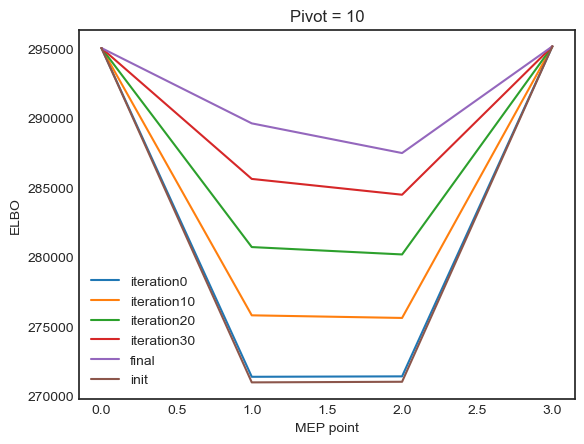

In [454]:
for i in range(len(total_ELBO_list)):
    if i % 10 == 0:
        plt.plot(total_ELBO_list[i], label = 'iteration{}'.format(i))
        
plt.plot(total_ELBO_list[-2], label = 'final')
p_list_init = init(theta1, theta2, N)
ELBO_list_init = []
for p in p_list_init: 
    LAMBDA, GAMMA, PHI = p 
    elbo = compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)
    ELBO_list_init.append(elbo) 
plt.plot(ELBO_list_init ,label = 'init')
plt.xlabel("MEP point") 
plt.ylabel("ELBO")
plt.title("Pivot = 10")
plt.legend()

### contour plot 

Dimensionality reduction of parameters into 2d 
- choose two orthogonal random directions in high dimension and project onto these two dimensions to obtain a 2d embedding

In [363]:
p_list = His[-1]

## Normal

In [364]:
LAMBDA, GAMMA, PHI = theta1

norm_1 = 0
d1_LAMBDA = np.random.normal(0, 1, LAMBDA.shape)
norm_1 += np.square(np.linalg.norm(d1_LAMBDA)) 
d1_GAMMA = np.random.normal(0, 1, GAMMA.shape)
norm_1 += np.square(np.linalg.norm(d1_GAMMA)) 
d1_PHI = [np.random.normal(0, 1, i.shape) for i in PHI]

for d1_phi in d1_PHI:
    norm_1 += np.square(np.linalg.norm(d1_phi)) 

norm_1 = np.sqrt(norm_1)
d1_LAMBDA /= norm_1 
d1_GAMMA /= norm_1 
d1_PHI = [d1_phi/norm_1 for d1_phi in d1_PHI]

norm_2 = 0

d2_LAMBDA = np.random.normal(0, 1, LAMBDA.shape)
norm_2 += np.square(np.linalg.norm(d2_LAMBDA)) 
d2_GAMMA = np.random.normal(0, 1, GAMMA.shape)
norm_2 += np.square(np.linalg.norm(d2_GAMMA)) 
d2_PHI = [np.random.normal(0, 1, i.shape) for i in PHI]

for d2_phi in d1_PHI:
    norm_2 += np.square(np.linalg.norm(d2_phi)) 

norm_2 = np.sqrt(norm_2)
d2_LAMBDA /= norm_2 
d2_GAMMA /= norm_2
d2_PHI = [d2_phi / norm_2 for d2_phi in d2_PHI]  

center = init(theta1, theta2, N = 2)[1]
center_LAMBDA, center_GAMMA, center_PHI = center

    
def projection(pp_list, center):
    x_list = np.zeros(len(pp_list))
    y_list = np.zeros(len(pp_list))

    center_LAMBDA, center_GAMMA, center_PHI = center

    for i in range(len(pp_list)):
        LAMBDA, GAMMA, PHI = pp_list[i]
        LAMBDA_P = LAMBDA - center_LAMBDA
        x_list[i] += np.sum(d1_LAMBDA * LAMBDA_P)
        GAMMA_P = GAMMA - center_GAMMA
        x_list[i] += np.sum(d1_GAMMA * GAMMA_P)
        PHI_P = [phi - center_phi for (center_phi, phi) in zip(center_PHI, PHI)]
        x_list[i] += np.sum(np.array([np.sum(d1_phi * phi_p) for (d1_phi, phi_p) in zip(d1_PHI, PHI_P)]))

        y_list[i] += np.sum(d2_LAMBDA * LAMBDA_P)
        y_list[i] += np.sum(d2_GAMMA * GAMMA_P)
        y_list[i] += np.sum(np.array([np.sum(d2_phi * phi_p) for (d2_phi, phi_p) in zip(d2_PHI, PHI_P)]))
        
    return x_list, y_list



## Bern

In [297]:
LAMBDA, GAMMA, PHI = theta1

norm_1 = 0
d1_LAMBDA = np.random.binomial(1, 0.5, LAMBDA.shape).astype(float)
d2_LAMBDA = np.ones(LAMBDA.shape) - d1_LAMBDA

d1_GAMMA = np.random.binomial(1, 0.5, GAMMA.shape).astype(float)
d2_GAMMA = np.ones(GAMMA.shape) - d1_GAMMA

d1_PHI = [np.random.binomial(1, 0.5, i.shape).astype(float) for i in PHI]
d2_PHI = [np.ones(i.shape) - i for i in d1_PHI]



norm_1 += np.square(np.linalg.norm(d1_LAMBDA))
norm_1 += np.square(np.linalg.norm(d1_GAMMA)) 


for d1_phi in d1_PHI:
    norm_1 += np.square(np.linalg.norm(d1_phi)) 

norm_1 = np.sqrt(norm_1)
d1_LAMBDA /= norm_1 
d1_GAMMA /= norm_1 
d1_PHI = [d1_phi/norm_1 for d1_phi in d1_PHI]

norm_2 = 0

norm_2 += np.square(np.linalg.norm(d2_LAMBDA)) 
norm_2 += np.square(np.linalg.norm(d2_GAMMA)) 

for d2_phi in d1_PHI:
    norm_2 += np.square(np.linalg.norm(d2_phi)) 

norm_2 = np.sqrt(norm_2)
d2_LAMBDA /= norm_2 
d2_GAMMA /= norm_2
d2_PHI = [d2_phi / norm_2 for d2_phi in d2_PHI]  

center = init(theta1, theta2, N = 2)[1]
center_LAMBDA, center_GAMMA, center_PHI = center

    
def projection(pp_list, center):
    x_list = np.zeros(len(pp_list))
    y_list = np.zeros(len(pp_list))

    center_LAMBDA, center_GAMMA, center_PHI = center

    for i in range(len(pp_list)):
        LAMBDA, GAMMA, PHI = pp_list[i]
        LAMBDA_P = LAMBDA - center_LAMBDA
        x_list[i] += np.sum(d1_LAMBDA * LAMBDA_P)
        GAMMA_P = GAMMA - center_GAMMA
        x_list[i] += np.sum(d1_GAMMA * GAMMA_P)
        PHI_P = [phi - center_phi for (center_phi, phi) in zip(center_PHI, PHI)]
        x_list[i] += np.sum(np.array([np.sum(d1_phi * phi_p) for (d1_phi, phi_p) in zip(d1_PHI, PHI_P)]))

        y_list[i] += np.sum(d2_LAMBDA * LAMBDA_P)
        y_list[i] += np.sum(d2_GAMMA * GAMMA_P)
        y_list[i] += np.sum(np.array([np.sum(d2_phi * phi_p) for (d2_phi, phi_p) in zip(d2_PHI, PHI_P)]))
        
    return x_list, y_list

def point_projection(point):

    LAMBDA_P, GAMMA_P, PHI_P = point
    x = 0
    y = 0

    x += np.sum(d1_LAMBDA * LAMBDA_P)
    x += np.sum(d1_GAMMA * GAMMA_P)
    x += np.sum(np.array([np.sum(d1_phi * phi_p) for (d1_phi, phi_p) in zip(d1_PHI, PHI_P)]))

    y += np.sum(d2_LAMBDA * LAMBDA_P)
    y += np.sum(d2_GAMMA * GAMMA_P)
    y += np.sum(np.array([np.sum(d2_phi * phi_p) for (d2_phi, phi_p) in zip(d2_PHI, PHI_P)]))
        
    return x, y

def line_projection(pp_list):
    x_list = np.zeros(len(pp_list))
    y_list = np.zeros(len(pp_list))
    
    for i in range(len(pp_list)):
        x_list[i],y_list[i] = point_projection(pp_list[i])
        
    return x_list, y_list

In [365]:
precision = 10
extend = precision / 2
loss_surface = np.zeros((precision+1,precision+1))
h_list = np.arange(-extend,extend+1,1) / 10
v_list = np.arange(-extend,extend+1,1) / 10

for i in range(precision+1):
    for j in range(precision+1): 
        print('i: ',i)
        print('j: ',j)
        d1 = h_list[i]
        d2 = v_list[j]
        NEW_LAMBDA = center_LAMBDA + d1 * d1_LAMBDA + d2 * d2_LAMBDA
        NEW_GAMMA = center_GAMMA + d1 * d1_GAMMA + d2 * d2_GAMMA
        NEW_PHI = [center_phi + d1 * d1_phi + d2 * d2_phi for (center_phi, d1_phi,d2_phi) in zip(center_PHI, d1_PHI , d2_PHI)]
        loss_surface[i,j] = compute_elbo(NEW_LAMBDA, NEW_GAMMA, NEW_PHI,train_articles, train_nonzero_idxs, C)

#TODO 
#plot loss_surface 


#TODO 
#plots points (p_list) on the loss surface by first centering the points and then projecting them onto d1 and d2 

i:  0
j:  0
ELBO: 451875.11847957777
i:  0
j:  1
ELBO: 452581.70150026056
i:  0
j:  2
ELBO: 453079.94931640796
i:  0
j:  3
ELBO: 453416.72613271466
i:  0
j:  4
ELBO: 453616.4658901354
i:  0
j:  5
ELBO: 453691.5583229924
i:  0
j:  6
ELBO: 453645.8202566358
i:  0
j:  7
ELBO: 453475.15478827973
i:  0
j:  8
ELBO: 453166.6341638883
i:  0
j:  9
ELBO: 452694.55047968973
i:  0
j:  10
ELBO: 452007.8840609394
i:  1
j:  0
ELBO: 452485.3809507992
i:  1
j:  1
ELBO: 453122.9654751542
i:  1
j:  2
ELBO: 453579.35590001603
i:  1
j:  3
ELBO: 453890.530359753
i:  1
j:  4
ELBO: 454076.4383776935
i:  1
j:  5
ELBO: 454147.5039204971
i:  1
j:  6
ELBO: 454106.9901690028
i:  1
j:  7
ELBO: 453951.43766775733
i:  1
j:  8
ELBO: 453670.1015544602
i:  1
j:  9
ELBO: 453242.3129958638
i:  1
j:  10
ELBO: 452630.5390847259
i:  2
j:  0
ELBO: 452916.40647540905
i:  2
j:  1
ELBO: 453510.8479205278
i:  2
j:  2
ELBO: 453940.00006841397
i:  2
j:  3
ELBO: 454234.1544250138
i:  2
j:  4
ELBO: 454410.8428458419
i:  2
j:  5
ELBO:

In [381]:
center_x, center_y = point_projection(center)
v_list += center_y
h_list += center_x

p_list_init = init(theta1, theta2, N)
init_x,init_y = line_projection(p_list_init)
x_list, y_list = line_projection(p_list)

In [382]:
elbo_init = []
for p in p_list_init: 
    LAMBDA, GAMMA, PHI = p 
    elbo_init.append(compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C))

ELBO: 458804.3358301647
ELBO: 455082.2664616831
ELBO: 455071.88631429255
ELBO: 458780.8891626676


In [383]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

x = x_list
y = y_list
z = total_ELBO_list[-1]
color1=["b" for i in range(len(x_list))]
df = pd.DataFrame({"x": x, "y":y, "z":z, "color":color1})

fig1 = px.line_3d(df, x="x", y="y", z="z", color="color" ,color_discrete_map={ "a": "RebeccaPurple"})

x2 = init_x
y2 = init_y
z2 = elbo_init
df = pd.DataFrame({"x": x2, "y":y2, "z":z2})

fig2 = px.line_3d(df, x="x", y="y", z="z")

fig3 = go.Figure(data=[go.Surface(x=h_list, y=v_list, z=loss_surface)])

fig = go.Figure(data = fig1.data + fig2.data +fig3.data)
fig.show()

In [379]:
init_y

array([-1.3253853 , -1.44241361, -1.55944192, -1.67647023])

### out of sample performance


In [360]:
idx_to_words, articles, nonzero_idxs = load_data(BOW_PATH,VOCAB_PATH, trim = 1)
test_articles = articles[-100:]
test_nonzero_idxs = nonzero_idxs[-100:]

/var/folders/mw/9bfg1rf52g57tm0mgxqjy4gm0000gn/T/ipykernel_55007/2775555696.py:22: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Loading index-to-word mapping...
Loading article bag-of-word representations...
2246 articles found.


100%|████████████████████████████████████| 2246/2246 [00:00<00:00, 15944.23it/s]


In [362]:
score_his = []
for p_list in His:
    Out_score = []
    for p in p_list:
        LAMBDA, GAMMA, PHI = p
        Out_score.append(compute_pred_score(LAMBDA, GAMMA, PHI, test_articles, test_nonzero_idxs, test_word_idxs))
    score_his.append(copy.deepcopy(Out_score))

IndexError: index 12 is out of bounds for axis 0 with size 12

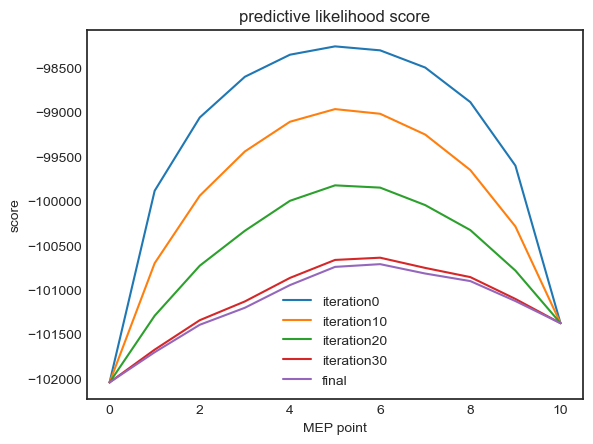

In [257]:
for i in range(len(score_his)):
    if i % 10 == 0:
        plt.plot(score_his[i], label = 'iteration{}'.format(i)) 
plt.plot(score_his[-1], label = 'final')

plt.xlabel("MEP point") 
plt.ylabel("score")
plt.title('predictive likelihood score')
plt.legend()

plt.savefig(PATH + '/Result/pred_score_test1', dpi=600, facecolor='w', transparent=True)